In [1]:
import colorsys
import os
import time
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as K
from PIL import ImageDraw, ImageFont, Image
#import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np

from nets.yolo import yolo_body
from utils.utils import (cvtColor, get_anchors, get_classes, preprocess_input,
                         resize_image, show_config)
from utils.utils_bbox import DecodeBox

In [2]:
tf.disable_eager_execution()

## 參數設置

In [3]:
model_path='logs/best_epoch_weights.h5'
classes_path='model_data/cls_classes.txt'
anchors_path='model_data/yolo_anchors.txt'
anchors_mask=[[6, 7, 8], [3, 4, 5], [0, 1, 2]]
input_shape=[416, 416]
confidence=0.5
nms_iou=0.3
max_boxes=100
letterbox_image=False

In [4]:
class_names, num_classes = get_classes(classes_path)
anchors, num_anchors = get_anchors(anchors_path)

In [5]:
hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
input_image_shape = K.placeholder(shape=(2, ))

sess = tf.compat.v1.keras.backend.get_session()

## 載入模型

In [6]:
model_path = os.path.expanduser(model_path)

yolo_model = yolo_body([None, None, 3], anchors_mask, num_classes)
yolo_model.load_weights(model_path)
print('{} model, anchors, and classes loaded.'.format(model_path))

boxes, scores, classes = DecodeBox(
    yolo_model.output, 
    anchors,
    num_classes, 
    input_image_shape, 
    input_shape, 

    anchor_mask     = anchors_mask,
    max_boxes       = max_boxes,
    confidence      = confidence, 
    nms_iou         = nms_iou, 
    letterbox_image = letterbox_image
)

logs/best_epoch_weights.h5 model, anchors, and classes loaded.


## 載入圖片

In [56]:
image = Image.open('Data/test/test_img/3.jpg')
image = cvtColor(image)

# 後續處理所需之設定
font = ImageFont.truetype(font='model_data/simhei.ttf', size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
thickness = int(max((image.size[0] + image.size[1]) // np.mean(input_shape), 1))

## 預測

In [57]:
image_data  = resize_image(image, (input_shape[1], input_shape[0]), letterbox_image)
image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)

out_boxes, out_scores, out_classes = sess.run(
    [boxes, scores, classes],
    feed_dict={
        yolo_model.input: image_data,
        input_image_shape: [image.size[1], image.size[0]],
        K.learning_phase(): 0})
print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

Found 1 boxes for img


In [58]:
# 取得bounding box 四個點 座標

score = out_scores[0]
top, left, bottom, right = out_boxes[0]

top = max(0, np.floor(top).astype('int32'))
left = max(0, np.floor(left).astype('int32'))
bottom = min(image.size[1], np.floor(bottom).astype('int32'))
right = min(image.size[0], np.floor(right).astype('int32'))

## 切割
切割後將圖片放大3倍，並轉成灰度圖

(189, 462)


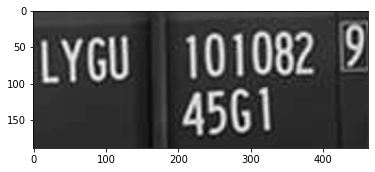

In [59]:
crop_image = image.crop([left, top, right+5, bottom+5])
width = crop_image.size[0] * 3
height = crop_image.size[1] * 3
crop_image = crop_image.resize((width, height))
crop_image = crop_image.convert('L')
crop_image = np.array(crop_image)

print(crop_image.shape)
plt.imshow(crop_image, 'gray')
plt.show()

## 用高斯雙邊模糊去雜訊
他比起高斯模糊更能保留邊緣的資訊，所以我認為有利於檢測

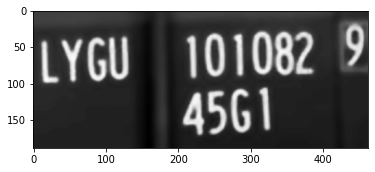

In [60]:
dst = cv2.bilateralFilter(crop_image, 0, 50, 6)
plt.imshow(dst, 'gray')
plt.show()

(189, 462)


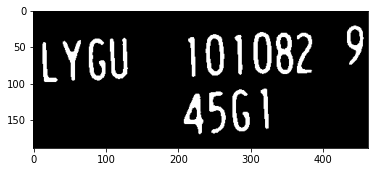

In [61]:
r, ocr_image = cv2.threshold(dst, 170, 255, cv2.THRESH_BINARY)

print(ocr_image.shape)
plt.imshow(ocr_image, 'gray')
plt.show()

In [62]:
import easyocr

In [63]:
text_reader = easyocr.Reader(['en'])
results = text_reader.readtext(ocr_image)
results

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 27], [143, 27], [143, 108], [0, 108]], 'LYGU', 0.8983876705169678),
 ([[199, 14], [401, 14], [401, 104], [199, 104]],
  '10 1082',
  0.660672073017865),
 ([[428, 18], [460, 18], [460, 74], [428, 74]], '9', 0.9998066518791262),
 ([[194, 95], [341, 95], [341, 182], [194, 182]], '4561', 0.9898450970649719)]

## 文字格式處理

In [64]:
## 合併文字以及處理數字1辨識錯誤問題
label = ''
for box, txt, cof in results:
    for t in txt:
        if not(t.isalpha()) and not(t.isdigit()):
            if t == ' ':
                continue
            else:
                t = '1'
        label = label + t

label

'LYGU10108294561'

In [65]:
## 格式整理
#### XXXX XXXXXX X XXXX
format = [4, 6, 1, 4, 0]
format_point = 0
i = 0
text=''
for t in label:
    text = text + t
    i = i + 1
    if i == format[format_point]:
        if format[format_point+1] != 0:
            text = text + ' '
            i = 0
            format_point = format_point + 1
        else:
            break
text

'LYGU 101082 9 4561'

In [66]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

預測： LYGU 101082 9 4561
位置： 117 336 175 485


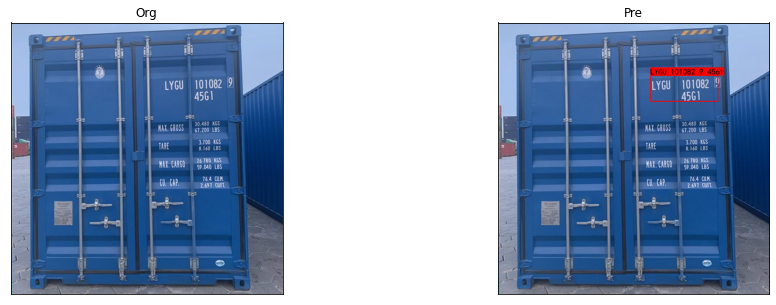

In [67]:
label = text
img_pre = image.copy()
draw = ImageDraw.Draw(img_pre)

print('預測：', label)
print('位置：', top, left, bottom, right)
label_size = draw.textsize(label, font)
label = label.encode('utf-8')


if top - label_size[1] >= 0:
    text_origin = np.array([left, top - label_size[1]])
else:
    text_origin = np.array([left, top + 1])

for i in range(thickness):
    draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[out_classes[0]])
draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[out_classes[0]])
draw.text(text_origin, str(label,'UTF-8'), fill=(0, 0, 0), font=font)
del draw

visualize(org=image, pre=img_pre)